**Install requirements**

In [ ]:
!pip install segmentation-models-pytorch
!pip install torchmetrics
!pip install fvcore
!pip install ptflops

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 13.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=5cd142f06fd5faa4d6d8d996b2bf872767e58f3c5045c49ee3cc07d8b72a67c7
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=5cfe5b204ae454390dcaa47567ae1168cbfb497e03124299eedeee15c3bc7020
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 k

**Import libraries**

In [ ]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import jaccard_score

import time

from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# **Global variables**

In [ ]:
NUM_CLASSES = 7

BATCH_SIZE = 16     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                    # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.01             # The initial Learning Rate
MOMENTUM = 0.9        # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 0.0001 # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)

# **Dataset management**

**Download Dataset LoveDA**


In [ ]:
# Copia il file da cartella Google Drive a /content
#1yzLCHM-BHGaEvt5DqnCBzaLfLF-qOQ7M
if not os.path.isdir('/content/LoveDA'):
  !gdown --id 1yzLCHM-BHGaEvt5DqnCBzaLfLF-qOQ7M # 3-5 min
  !jar xvf  "/content/LoveDA.zip"

# Controlla se il dataset è stato copiato correttamente
if not os.path.isdir('/content/LoveDA'):
    print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/deeplab_resnet_pretrained_imagenet.pth"):
  !gdown --id 1NvuTouMX4J94i2W3SY9S0Hy2N0WdHu8D

if not os.path.isfile("/content/best_model_deeplab_v2.pth"):
  !gdown --id 1sa20uWvZSmH7LkGy4XIk2vaTIYBxcWo-

'''
# OPTION 2
# Download LoveDA train an val dataset, from https://zenodo.org/records/5706578, extract and put them in a unique folder: LoveDA
# Download the Utils folder from github: https://github.com/Zafonte/Real-time-Domain-Adaptation-in-Semantic-Segmentation.git
# Upload in your drive the dataset and the Utils folder - then run the following line of code
from google.colab import drive
drive.mount('/content/drive')

# Copy the dataset from your Google Drive folder to /content
if not os.path.isdir('/content/LoveDA'):
    !cp -r "/content/drive/MyDrive/AMLProjectCode/LoveDA" /content/                        #PUT your path

# Check if the dataset has been copied correctly
if not os.path.isdir('/content/LoveDA'):
    print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/deeplab_resnet_pretrained_imagenet.pth"):
  !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/deeplab_resnet_pretrained_imagenet.pth" /content/  #PUT your path

if not os.path.isfile("/content/best_model_deeplab_v2.pth"):
  !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/best_model_deeplab_v2.pth" /content/     #PUT your path

# Utilities
if not os.path.isfile("/content/model_utils.py"):
    !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/model_utils.py" /content/           #PUT your path

'''

Streaming output truncated to the last 5000 lines.
 inflated: LoveDA/Train/Urban/images_png/2032.png
 inflated: LoveDA/Train/Urban/images_png/2033.png
 inflated: LoveDA/Train/Urban/images_png/2034.png
 inflated: LoveDA/Train/Urban/images_png/2035.png
 inflated: LoveDA/Train/Urban/images_png/2036.png
 inflated: LoveDA/Train/Urban/images_png/2037.png
 inflated: LoveDA/Train/Urban/images_png/2038.png
 inflated: LoveDA/Train/Urban/images_png/2039.png
 inflated: LoveDA/Train/Urban/images_png/2040.png
 inflated: LoveDA/Train/Urban/images_png/2041.png
 inflated: LoveDA/Train/Urban/images_png/2042.png
 inflated: LoveDA/Train/Urban/images_png/2043.png
 inflated: LoveDA/Train/Urban/images_png/2044.png
 inflated: LoveDA/Train/Urban/images_png/2045.png
 inflated: LoveDA/Train/Urban/images_png/2046.png
 inflated: LoveDA/Train/Urban/images_png/2047.png
 inflated: LoveDA/Train/Urban/images_png/2048.png
 inflated: LoveDA/Train/Urban/images_png/2049.png
 inflated: LoveDA/Train/Urban/images_png/2050.png

' OPZIONE 2\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\n# Scaricare loveDA dataset e inserirlo nella cartella /content/drive/MyDrive/AMLProjectCode\n# Copia il dataset dalla cartella di Google Drive a /content\nif not os.path.isdir(\'/content/LoveDA\'):\n    !cp -r "/content/drive/MyDrive/AMLProjectCode/LoveDA" /content/\n\n# Controlla se il dataset è stato copiato correttamente\nif not os.path.isdir(\'/content/LoveDA\'):\n    print("Dataset doesn\'t exist")\n'

**LoveDA dataset class**


In [ ]:
COLOR_MAP = OrderedDict(
    Black = (0, 0, 0),
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(0, 255, 0),
    Agricultural=(255, 195, 128),
)


LABEL_MAP = OrderedDict(
    Black = -1,
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)


def map_labels(label):
    mapped_label = np.where(label == 0, -1, np.where(label >= 1, label - 1, label)) # Change pixel values
    return torch.tensor(mapped_label, dtype=torch.long)


class LoveDADataset(Dataset):
    def __init__(self, images_path, masks_path, image_transform=None, mask_transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = sorted([f for f in os.listdir(images_path) if f.endswith('.png')])
        self.masks = sorted([f for f in os.listdir(masks_path) if f.endswith('.png')])

        # Check if the number of images matches the number of masks
        if len(self.images) != len(self.masks):
            raise ValueError("The number of images and masks does not match!")

    def __getitem__(self, idx):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target)
        '''
        # Read image and mask
        image = Image.open(os.path.join(self.images_path, self.images[idx])).convert('RGB')
        mask = Image.open(os.path.join(self.masks_path, self.masks[idx]))

        # Apply transformation to images (if present)
        if self.image_transform:
            image = self.image_transform(image)

        # Apply transformation to masks (if present)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Convert mask to NumPy array for mapping
        mask_np = np.array(mask, dtype=np.int64)

        # Map labels using map_labels function
        mask_mapped = map_labels(mask_np)

        return image, mask_mapped

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        return len(self.images)


# **Network setup**

**DeepLabV2**: a classic segmentation network

In [ ]:
# Classifier
'''
This module creates a list of convolutions with varying dilation and padding values.
Dilation: is a technique that increases the field of view of convolutions without adding parameters or reducing resolution. It is useful for capturing information from a wider context.
'''
class ClassifierModule(nn.Module):
    def __init__(self, inplanes, dilation_series, padding_series, num_classes):
        super(ClassifierModule, self).__init__()
        self.conv2d_list = nn.ModuleList()
        for dilation, padding in zip(dilation_series, padding_series):
            self.conv2d_list.append(
                nn.Conv2d(inplanes, num_classes, kernel_size=3, stride=1, padding=padding,
                          dilation=dilation, bias=True))

        for m in self.conv2d_list:
            m.weight.data.normal_(0, 0.01)

    def forward(self, x):
        '''Each convolution in the conv2d_list processes
        the same input x and the results are summed.
        '''
        out = self.conv2d_list[0](x)
        for i in range(len(self.conv2d_list) - 1):
            out += self.conv2d_list[i + 1](x)
        return out

# Bottleneck
'''
Base block of ResNet
'''
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)  # Reduces channel count
        self.bn1 = nn.BatchNorm2d(planes, affine=affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        padding = dilation
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=padding, bias=False, dilation=dilation)  # Applies a 3x3 convolution
        self.bn2 = nn.BatchNorm2d(planes, affine=affine_par)
        for i in self.bn2.parameters():
            i.requires_grad = False
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)  # Restores original channel count
        self.bn3 = nn.BatchNorm2d(planes * 4, affine=affine_par)
        for i in self.bn3.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)  # Activation function
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

affine_par = True

# ResNetMulti
'''
This is the main model.
It combines multiple convolutional layers, residual blocks, and the ClassifierModule.
'''
class ResNetMulti(nn.Module):
    def __init__(self, block, layers, num_classes):
        self.inplanes = 64
        super(ResNetMulti, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, affine=affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)  # change
        # Layer1–4: Stacking bottleneck blocks progressively reduces the image resolution and extracts more abstract features.
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)
        # Layer6: Classifier that segments pixels using convolutions with varying dilations.
        self.layer6 = ClassifierModule(2048, [6, 12, 18, 24], [6, 12, 18, 24], num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        '''
        Building the model
        '''
        downsample = None
        if (stride != 1
                or self.inplanes != planes * block.expansion
                or dilation == 2
                or dilation == 4):
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, affine=affine_par))
        for i in downsample._modules['1'].parameters():
            i.requires_grad = False
        layers = []
        layers.append(
            block(self.inplanes, planes, stride, dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        _, _, H, W = x.size()  # Extract input dimensions

        # Pass the image through convolutional layers and residual blocks:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Pass the output to the classifier:
        x = self.layer6(x)

        # Upsample (interpolate) the output to match the original input dimensions
        x = torch.nn.functional.interpolate(x, size=(H, W), mode='bilinear')

        # During training:
        if self.training == True:
            ''' Returns a tuple:
            - x: probability map with dimensions (batch_size, num_classes, H, W)
            - the other two values are placeholders (potentially used for multi-task learning in other model variants).
            '''
            return x, None, None

        ''' x is a probability map of size (batch_size, num_classes, H, W)
            Each position (i, j) in the map represents a pixel from the original image.
            The vector of size num_classes at each position contains the (unnormalized, logits) probability that that pixel belongs to each class.
        '''
        return x

    def get_1x_lr_params_no_scale(self):
        """
        This generator returns all the parameters of the net except for the last classification layer.
        Note that for each batchnorm layer, requires_grad is set to False in deeplab_resnet.py,
        therefore this function does not return any batchnorm parameter
        """
        b = []

        b.append(self.conv1)
        b.append(self.bn1)
        b.append(self.layer1)
        b.append(self.layer2)
        b.append(self.layer3)
        b.append(self.layer4)

        for i in range(len(b)):
            for j in b[i].modules():
                jj = 0
                for k in j.parameters():
                    jj += 1
                    if k.requires_grad:
                        yield k

    def get_10x_lr_params(self):
        """
        This generator returns all the parameters for the last layer of the net,
        which does the classification of pixel into classes
        """
        b = []
        if self.multi_level:
            b.append(self.layer5.parameters())
        b.append(self.layer6.parameters())

        for j in range(len(b)):
            for i in b[j]:
                yield i

    def optim_parameters(self, lr):
        return [{'params': self.get_1x_lr_params_no_scale(), 'lr': lr},
                {'params': self.get_10x_lr_params(), 'lr': 10 * lr}]

# Function to load the model

def get_deeplab_v2(num_classes=7, pretrain=True, pretrain_model_path="/content/deeplab_resnet_pretrained_imagenet.pth"):
    model = ResNetMulti(Bottleneck, [3, 4, 23, 3], num_classes)

    # Pretraining loading
    if pretrain:
        print('Deeplab pretraining on ImageNet loading...')
        saved_state_dict = torch.load(pretrain_model_path, weights_only=True)

        new_params = model.state_dict().copy()
        for i in saved_state_dict:
            i_parts = i.split('.')
            new_params['.'.join(i_parts[1:])] = saved_state_dict[i]
        model.load_state_dict(new_params, strict=False)

    return model


**Visualize prediction function**

In [ ]:
def visualize_prediction(image, true_mask, pred_mask):
    """
    Visualizes the original image, true mask, and predicted mask.
    Parameters:
    - image: Tensor image (C, H, W).
    - true_mask: Tensor ground truth mask.
    - pred_mask: Tensor predicted mask.
    """

    print("Comparison of true mask and prediction for a sample train image:")

    # Define ImageNet mean and standard deviation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image = image.cpu().numpy().transpose(1, 2, 0)  # Change image shape for matplotlib

    # If the image was normalized for the model, we need to de-normalize it
    # De-normalize the image
    image = image * std + mean  # Inverse of normalization
    image = np.clip(image, 0, 1)  # Ensure values are in the range [0, 1]

    # Convert image and masks to numpy arrays for visualization
    true_mask_np = np.array(true_mask.cpu(), dtype=np.int64)
    pred_mask_np = np.array(pred_mask.cpu(), dtype=np.int64)

    # Create a colored mask based on LABEL_MAP and COLOR_MAP
    colored_true_mask = np.zeros((true_mask_np.shape[0], true_mask_np.shape[1], 3), dtype=np.uint8)
    colored_pred_mask = np.zeros((pred_mask_np.shape[0], pred_mask_np.shape[1], 3), dtype=np.uint8)
    for class_name, color in COLOR_MAP.items():
        class_value = LABEL_MAP[class_name]  # Get the numerical value for the class
        colored_true_mask[true_mask_np == class_value] = color  # Apply correct color
        colored_pred_mask[pred_mask_np == class_value] = color  # Apply correct color

    # Create figure with subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # True mask
    ax[1].imshow(colored_true_mask)
    ax[1].set_title('True Mask')
    ax[1].axis('off')
    print(f"Unique values (mapped) in true mask: {np.unique(true_mask_np)}")

    # Predicted mask
    ax[2].imshow(colored_pred_mask)
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    print(f"Unique values in predicted mask: {np.unique(pred_mask_np)}")
    print()

    legend_patches = [mpatches.Patch(color=np.array(color) / 255.0, label=class_name) for class_name, color in COLOR_MAP.items()]
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    # Save or show the image
    plt.show()


# **Define Data Preprocessing**

In [ ]:
# Image transformation
image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(), # Turn PIL Image to torch.Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization - Pre-trained models on ImageNet (such as ResNet101 for DeepLabV2 and PIDNet-S) expect normalized images.
])

# Mask transformation
mask_transform = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)


# **Dataset object**

In [ ]:
train_dataset = LoveDADataset(
    "/content/LoveDA/Train/Urban/images_png",
    "/content/LoveDA/Train/Urban/masks_png",
    image_transform=image_transform,
    mask_transform=mask_transform
)

print(f"Number of images in the dataset: {len(train_dataset)}")

val_dataset = LoveDADataset(
    "/content/LoveDA/Val/Urban/images_png",
    "/content/LoveDA/Val/Urban/masks_png",
    image_transform=image_transform,
    mask_transform=mask_transform
)


Number of images in the dataset: 1156


# **Dataloaders**

In [ ]:
#DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) #batch_size: numero di immagini processate contemporaneamente
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# **Prepare Network**

In [ ]:
# model configuration
model = get_deeplab_v2(num_classes=NUM_CLASSES, pretrain=True, pretrain_model_path="/content/deeplab_resnet_pretrained_imagenet.pth")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Deeplab pretraining on ImageNet loading...


# **Validation setup**

In [ ]:
# Label mapping, excluding Black class (index -1)
LABEL = {
    'Background': 0,
    'Building': 1,
    'Road': 2,
    'Water': 3,
    'Barren': 4,
    'Forest': 5,
    'Agricultural': 6
}

# Function to compute confusion matrix
# a: ground truth, b: predictions, n: number of classes
def fast_hist(a, b, n):
    """
    Compute a confusion matrix between classes.

    Args:
        a (np.array): Ground truth (1D or 2D array).
        b (np.array): Prediction (1D or 2D array).
        n (int): Number of classes.

    Returns:
        np.array: Confusion matrix of shape n x n.
    """
    # Create a boolean index for valid values
    k = (a >= 0) & (a < n)

    # Compute confusion matrix
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

# Function to compute IoU per class
def per_class_iou(hist):
    epsilon = 1e-5  # Small constant to avoid division by zero
    # intersection = values on the diagonal of the confusion matrix
    return np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

# Function to compute mIoU on validation set
def compute_mIoU(model, val_loader, num_classes, device):
    model.eval()
    hist = np.zeros((num_classes, num_classes))

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Predicted class

            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            for lt, lp in zip(masks, preds):
                hist += fast_hist(lt.flatten(), lp.flatten(), num_classes)

    iou = per_class_iou(hist)
    mIoU = np.mean(iou)

    # Print IoU per class with class names
    print("IoU per category (%):")
    for class_idx in range(num_classes):
        class_name = list(LABEL.keys())[list(LABEL.values()).index(class_idx)]
        print(f" {class_name}: {iou[class_idx] * 100:.2f}%")
    print()

    print(f"mIoU: {mIoU * 100:.2f}%")
    print()
    return mIoU


# **Training**


In [ ]:
trained = True #SET to True if you want use the pretrained weights oterwise False
plot_training = False

Epoch 1/20:   0%|          | 0/73 [00:00<?, ?it/s]<ipython-input-29-8a8d76939220>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20: 100%|██████████| 73/73 [01:04<00:00,  1.12it/s]


Epoch 1, Learning Rate: 0.009555, Average Loss: 1.8530


IoU per category (%):
 Background: 28.40%
 Building: 17.27%
 Road: 23.43%
 Water: 24.26%
 Barren: 1.02%
 Forest: 0.05%
 Agricultural: 0.00%

mIoU: 13.49%

New best model saved with mIoU: 0.1349
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 3]



Epoch 2/20: 100%|██████████| 73/73 [01:02<00:00,  1.16it/s]


Epoch 2, Learning Rate: 0.009102, Average Loss: 1.0168


IoU per category (%):
 Background: 30.58%
 Building: 27.92%
 Road: 36.49%
 Water: 56.19%
 Barren: 23.25%
 Forest: 29.80%
 Agricultural: 11.04%

mIoU: 30.75%

New best model saved with mIoU: 0.3075
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2]
Unique values in predicted mask: [0 1 2 5]



Epoch 3/20: 100%|██████████| 73/73 [01:02<00:00,  1.16it/s]


Epoch 3, Learning Rate: 0.008646, Average Loss: 0.8953


IoU per category (%):
 Background: 29.88%
 Building: 37.27%
 Road: 41.78%
 Water: 42.43%
 Barren: 15.23%
 Forest: 31.39%
 Agricultural: 6.81%

mIoU: 29.25%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



Epoch 4/20: 100%|██████████| 73/73 [01:03<00:00,  1.15it/s]


Epoch 4, Learning Rate: 0.008187, Average Loss: 0.8204


IoU per category (%):
 Background: 32.44%
 Building: 31.41%
 Road: 46.97%
 Water: 59.69%
 Barren: 21.86%
 Forest: 29.10%
 Agricultural: 15.80%

mIoU: 33.89%

New best model saved with mIoU: 0.3389
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 5]



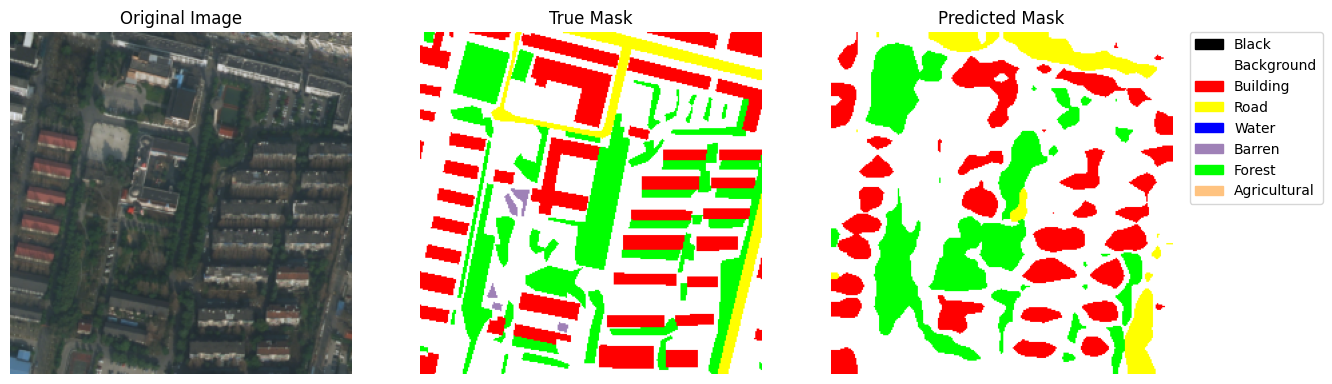

Epoch 5/20: 100%|██████████| 73/73 [01:03<00:00,  1.15it/s]


Epoch 5, Learning Rate: 0.007725, Average Loss: 0.7475


IoU per category (%):
 Background: 32.26%
 Building: 40.91%
 Road: 46.06%
 Water: 58.34%
 Barren: 26.85%
 Forest: 32.18%
 Agricultural: 24.58%

mIoU: 37.31%

New best model saved with mIoU: 0.3731
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 2 4 5]
Unique values in predicted mask: [0 1 2 3 4 5]



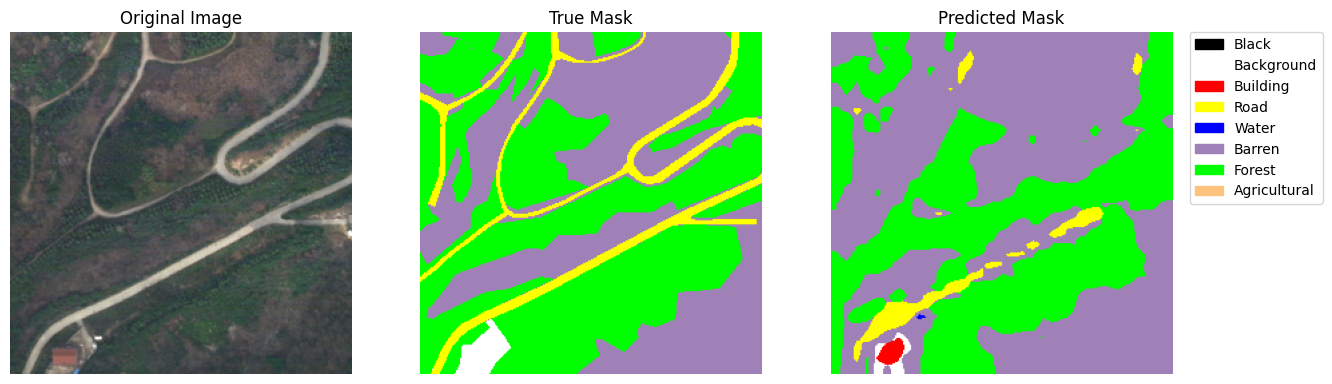

Epoch 6/20: 100%|██████████| 73/73 [01:04<00:00,  1.14it/s]


Epoch 6, Learning Rate: 0.007261, Average Loss: 0.6817


IoU per category (%):
 Background: 32.92%
 Building: 36.61%
 Road: 45.36%
 Water: 59.81%
 Barren: 16.64%
 Forest: 30.05%
 Agricultural: 21.79%

mIoU: 34.74%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



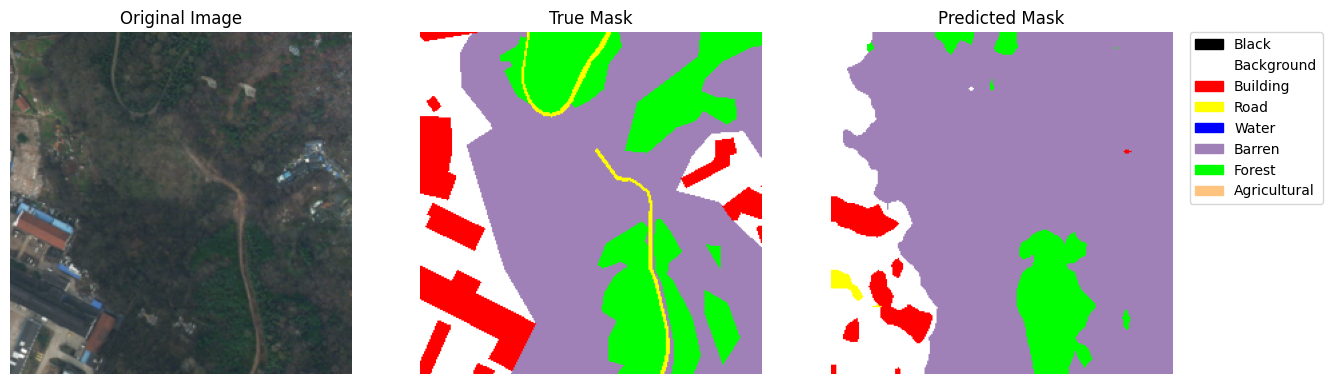

Epoch 7/20: 100%|██████████| 73/73 [01:03<00:00,  1.15it/s]


Epoch 7, Learning Rate: 0.006793, Average Loss: 0.6446


IoU per category (%):
 Background: 31.75%
 Building: 40.84%
 Road: 43.11%
 Water: 57.55%
 Barren: 15.56%
 Forest: 31.11%
 Agricultural: 15.37%

mIoU: 33.62%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 5]
Unique values in predicted mask: [0 1 2 5]



Epoch 8/20: 100%|██████████| 73/73 [01:03<00:00,  1.15it/s]


Epoch 8, Learning Rate: 0.006321, Average Loss: 0.5963


IoU per category (%):
 Background: 32.20%
 Building: 40.71%
 Road: 46.55%
 Water: 57.84%
 Barren: 23.22%
 Forest: 34.26%
 Agricultural: 15.82%

mIoU: 35.80%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



Epoch 9/20: 100%|██████████| 73/73 [01:04<00:00,  1.14it/s]


Epoch 9, Learning Rate: 0.005845, Average Loss: 0.5588


IoU per category (%):
 Background: 33.14%
 Building: 40.70%
 Road: 47.10%
 Water: 55.43%
 Barren: 25.05%
 Forest: 31.40%
 Agricultural: 18.40%

mIoU: 35.89%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 5]
Unique values in predicted mask: [0 1 2 5]



Epoch 10/20: 100%|██████████| 73/73 [01:03<00:00,  1.14it/s]


Epoch 10, Learning Rate: 0.005365, Average Loss: 0.5394


IoU per category (%):
 Background: 32.41%
 Building: 41.37%
 Road: 46.80%
 Water: 58.57%
 Barren: 25.88%
 Forest: 32.85%
 Agricultural: 15.68%

mIoU: 36.22%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 5]
Unique values in predicted mask: [0 1 2 5]



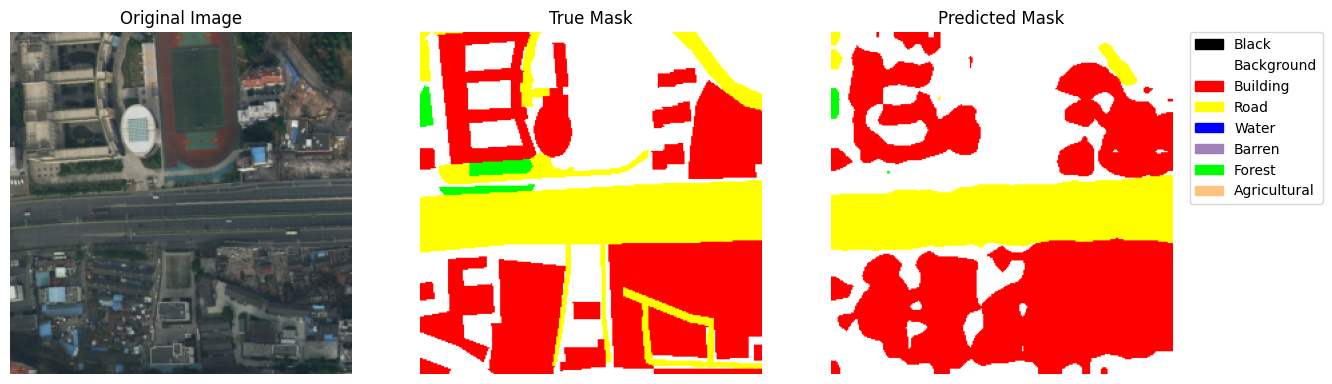

Epoch 11/20: 100%|██████████| 73/73 [01:04<00:00,  1.14it/s]


Epoch 11, Learning Rate: 0.004881, Average Loss: 0.5092


IoU per category (%):
 Background: 33.70%
 Building: 36.67%
 Road: 47.26%
 Water: 58.93%
 Barren: 23.41%
 Forest: 34.05%
 Agricultural: 20.29%

mIoU: 36.33%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  2  4  5]
Unique values in predicted mask: [0 1 2 4 5]



Epoch 12/20: 100%|██████████| 73/73 [01:04<00:00,  1.13it/s]


Epoch 12, Learning Rate: 0.004391, Average Loss: 0.4880


IoU per category (%):
 Background: 32.63%
 Building: 39.73%
 Road: 47.03%
 Water: 58.43%
 Barren: 24.41%
 Forest: 32.10%
 Agricultural: 17.84%

mIoU: 36.02%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



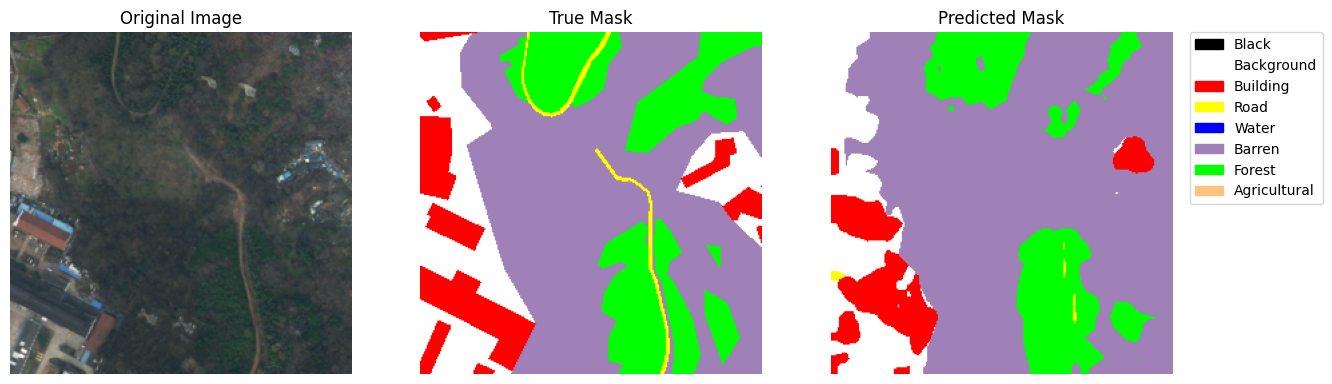

Epoch 13/20: 100%|██████████| 73/73 [01:04<00:00,  1.13it/s]


Epoch 13, Learning Rate: 0.003894, Average Loss: 0.4718


IoU per category (%):
 Background: 32.98%
 Building: 39.96%
 Road: 47.70%
 Water: 58.71%
 Barren: 22.35%
 Forest: 33.10%
 Agricultural: 21.62%

mIoU: 36.63%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5 6]



Epoch 14/20: 100%|██████████| 73/73 [01:04<00:00,  1.12it/s]


Epoch 14, Learning Rate: 0.003391, Average Loss: 0.4560


IoU per category (%):
 Background: 32.73%
 Building: 39.48%
 Road: 47.38%
 Water: 58.42%
 Barren: 25.05%
 Forest: 33.51%
 Agricultural: 17.94%

mIoU: 36.36%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



Epoch 15/20: 100%|██████████| 73/73 [01:04<00:00,  1.12it/s]


Epoch 15, Learning Rate: 0.002879, Average Loss: 0.4439


IoU per category (%):
 Background: 32.66%
 Building: 39.24%
 Road: 46.44%
 Water: 58.08%
 Barren: 23.54%
 Forest: 33.28%
 Agricultural: 17.41%

mIoU: 35.81%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  3]
Unique values in predicted mask: [0 1 3 4 5]



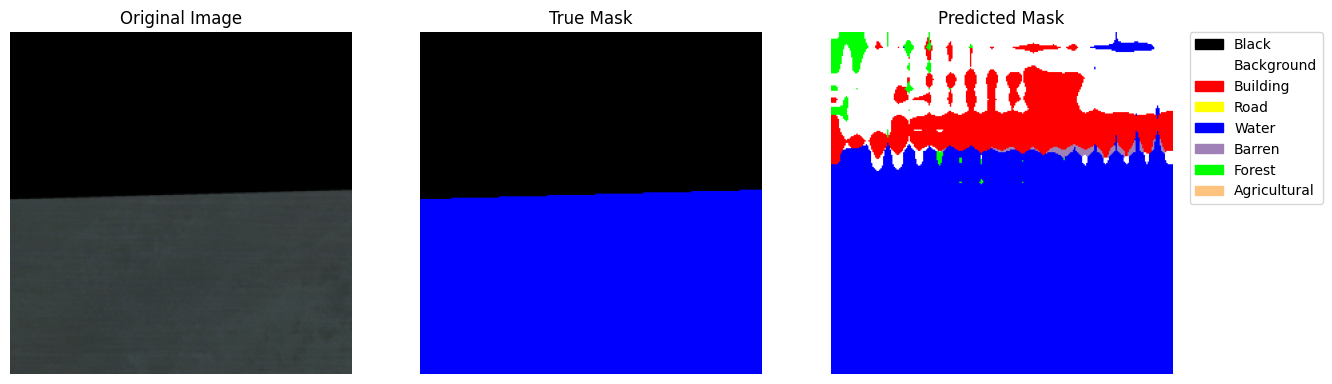

Epoch 16/20: 100%|██████████| 73/73 [01:05<00:00,  1.12it/s]


Epoch 16, Learning Rate: 0.002356, Average Loss: 0.4302


IoU per category (%):
 Background: 32.21%
 Building: 41.39%
 Road: 47.21%
 Water: 58.33%
 Barren: 23.34%
 Forest: 32.89%
 Agricultural: 19.20%

mIoU: 36.37%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  2  5]
Unique values in predicted mask: [0 1 2 3 5]



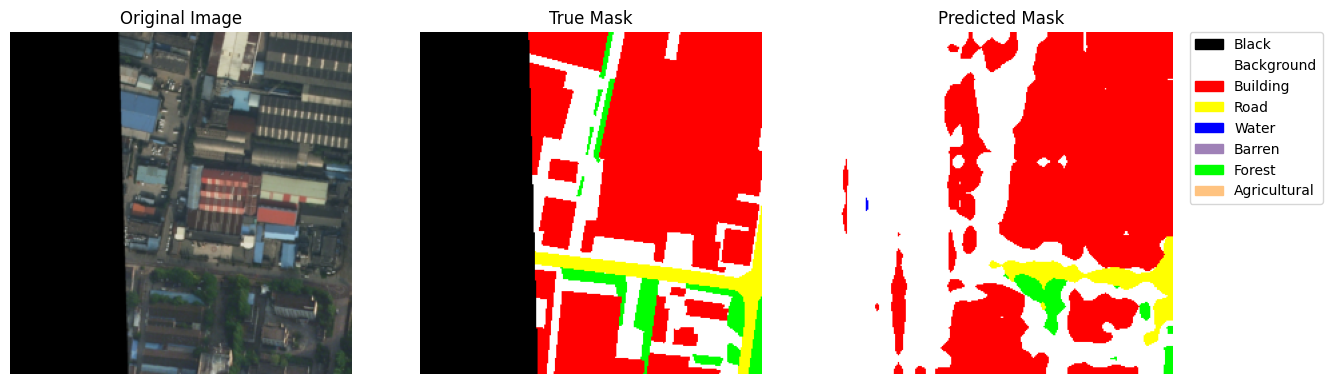

Epoch 17/20: 100%|██████████| 73/73 [01:14<00:00,  1.02s/it]


Epoch 17, Learning Rate: 0.001821, Average Loss: 0.4238


IoU per category (%):
 Background: 32.77%
 Building: 39.79%
 Road: 47.45%
 Water: 57.75%
 Barren: 23.11%
 Forest: 33.54%
 Agricultural: 20.24%

mIoU: 36.38%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 5 6]
Unique values in predicted mask: [0 1 2 3 5 6]



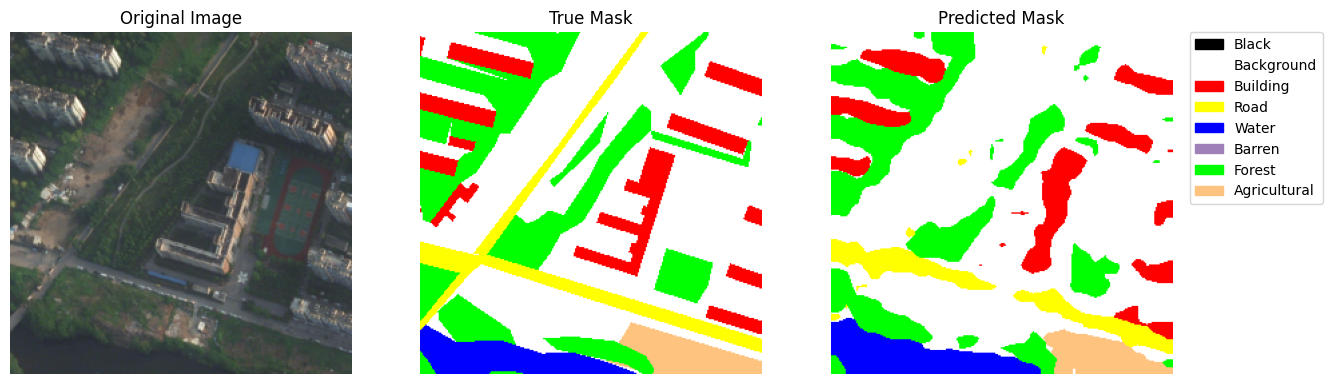

Epoch 18/20: 100%|██████████| 73/73 [01:06<00:00,  1.10it/s]


Epoch 18, Learning Rate: 0.001267, Average Loss: 0.4147


IoU per category (%):
 Background: 32.30%
 Building: 40.41%
 Road: 46.81%
 Water: 58.12%
 Barren: 24.18%
 Forest: 32.55%
 Agricultural: 17.86%

mIoU: 36.03%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 3 4 5]



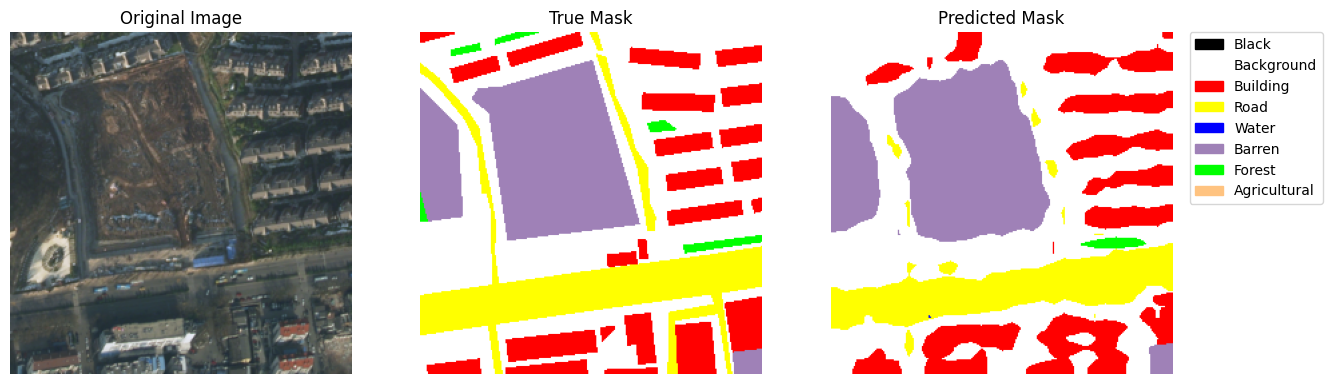

Epoch 19/20: 100%|██████████| 73/73 [01:06<00:00,  1.11it/s]


Epoch 19, Learning Rate: 0.000683, Average Loss: 0.4166


IoU per category (%):
 Background: 32.60%
 Building: 39.75%
 Road: 46.49%
 Water: 58.80%
 Barren: 21.84%
 Forest: 33.54%
 Agricultural: 18.32%

mIoU: 35.90%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



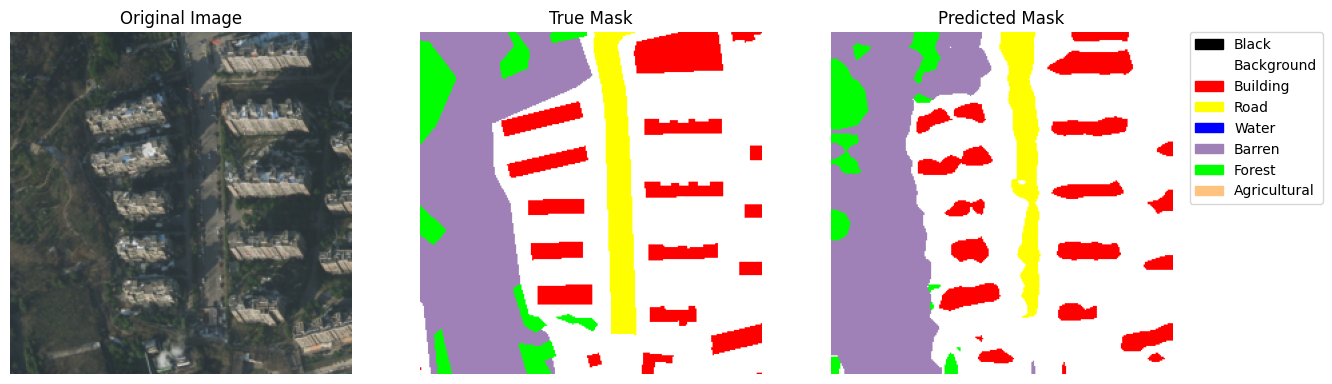

Epoch 20/20: 100%|██████████| 73/73 [01:06<00:00,  1.11it/s]


Epoch 20, Learning Rate: 0.000014, Average Loss: 0.4090


IoU per category (%):
 Background: 32.35%
 Building: 40.93%
 Road: 47.37%
 Water: 58.22%
 Barren: 23.63%
 Forest: 32.38%
 Agricultural: 19.17%

mIoU: 36.29%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



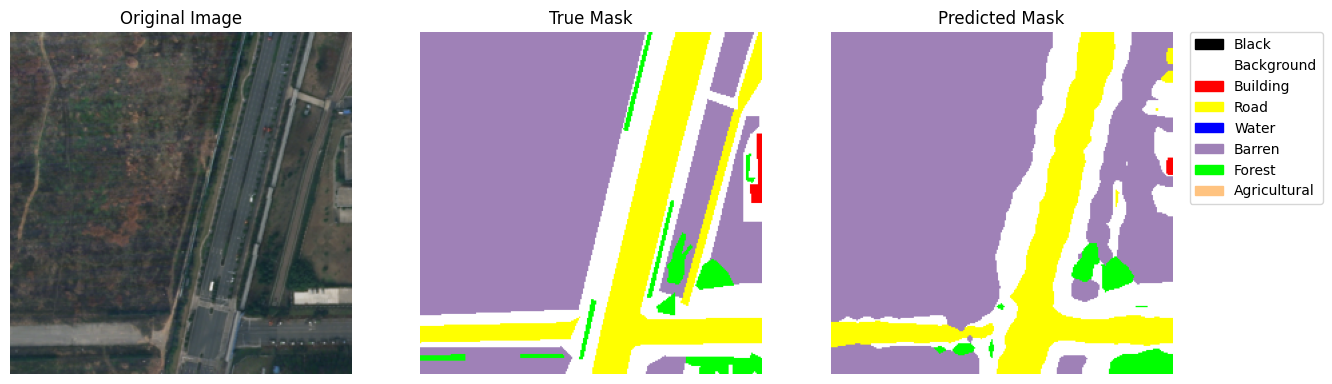

In [ ]:
# Scheduler
def poly_lr_scheduler(optimizer, init_lr, iter, max_iter, power=0.9):
    lr = init_lr * (1 - iter / max_iter) ** power
    optimizer.param_groups[0]['lr'] = lr
    return lr

# Optimizer configuration, loss function, and GradScaler
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

# Training loop
scaler = torch.amp.GradScaler()
num_epochs = NUM_EPOCHS
global_iter = 0  # Global iteration counter

loss_history = []
lr_history = []
miou_history = []

best_miou = 0.0  # Initialize best mIoU

if trained == False:
  for epoch in range(num_epochs):
      model.train()
      total_loss = 0.0

      for images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
          images, masks = images.to(device), masks.to(device)

          optimizer.zero_grad()
          with torch.cuda.amp.autocast():
              outputs = model(images)
              loss = criterion(outputs[0], masks)  # Compute loss

          scaler.scale(loss).backward()  # Backpropagation
          scaler.step(optimizer)              # Update weights
          scaler.update()                     # Update GradScaler

          lr = poly_lr_scheduler(optimizer, init_lr=LR, iter=global_iter, max_iter=len(train_loader) * num_epochs)
          global_iter += 1

          total_loss += loss.item()

      avg_loss = total_loss / len(train_loader)
      loss_history.append(avg_loss)  # Append to the list
      lr_history.append(lr)          # Append learning rate to the list
      print()
      print(f"Epoch {epoch + 1}, Learning Rate: {lr:.6f}, Average Loss: {avg_loss:.4f}")

      # Validation every epoch
      mIoU = compute_mIoU(model, val_loader, num_classes=NUM_CLASSES, device=device)
      miou_history.append(mIoU)
      # Save the best model based on mIoU
      if mIoU > best_miou:
          best_miou = mIoU
          torch.save(model.state_dict(), "best_model_deeplab_v2.pth")
          print(f"New best model saved with mIoU: {best_miou:.4f}")

      model.eval()
      '''Take a sample image and compare prediction'''
      # Load a batch of data
      sample_image, sample_label = next(iter(train_loader))  # A batch from DataLoader
      sample_image = sample_image[0]  # Select a single example
      sample_label = sample_label[0]

      # Get prediction from model
      with torch.no_grad():
          sample_image = sample_image.to(device)  # Transfer image to correct device
          pred_mask = model(sample_image.unsqueeze(0))  # Add batch dimension
          pred_mask = pred_mask.argmax(dim=1).squeeze(0)  # Predicted class

      # Visualize prediction
      visualize_prediction(sample_image, sample_label, pred_mask)

      trained = True
      plot_training = True
else:
  print("Model already trained")
  model.load_state_dict(torch.load("/content/best_model_deeplab_v2.pth", weights_only=True))
  model.to(device)

###Other Metrics


**Latency**

In [ ]:
import time

# Compute mean latency
def compute_latency(model, input_res, iterations=100, device=device):
    dummy_input = torch.randn(1, *input_res).to(device)
    latencies = []

    model.eval()
    torch.cuda.empty_cache()
    with torch.no_grad():
        _ = model(dummy_input)
        torch.cuda.synchronize()

        # Measure latency over multiple iterations
        for _ in range(iterations):
            start_time = time.time()
            _ = model(dummy_input)
            torch.cuda.synchronize()  # Ensure all operations are completed
            latencies.append((time.time() - start_time) * 1000)  # Convert to milliseconds

    mean_latency = np.mean(latencies)
    print(f"Mean Latency: {mean_latency:.3f} ms")
    return mean_latency

**FLOPs**

In [ ]:
from ptflops import get_model_complexity_info

# function to calculate FLOPs and model parameters
def compute_flops_params(model, input_res):
    with torch.no_grad():
        macs, params = get_model_complexity_info(model, input_res, as_strings=True, print_per_layer_stat=False)
        print(f"FLOPs: {macs}")
        print()
        print(f"Parameters: {params}")
    return macs, params

# **Results**

In [ ]:
model.load_state_dict(torch.load("/content/best_model_deeplab_v2.pth", weights_only=True))
# Assicurati che il dispositivo sia impostato correttamente (CPU o GPU)
model.to(device)
# Calculate mIoU
mIoU = compute_mIoU(model, val_loader, num_classes=NUM_CLASSES, device=device)

# Calculate latency
mean_latency = compute_latency(model, input_res=(3, 256, 256), device=device)

# Calculate FLOPs and parameters
flops, params = compute_flops_params(model, input_res=(3, 256, 256))


IoU per category (%):
 Background: 32.26%
 Building: 40.91%
 Road: 46.06%
 Water: 58.34%
 Barren: 26.85%
 Forest: 32.18%
 Agricultural: 24.58%

mIoU: 37.31%

Mean Latency: 35.468 ms
FLOPs: 47.79 GMac

Parameters: 42.91 M


## Final graph



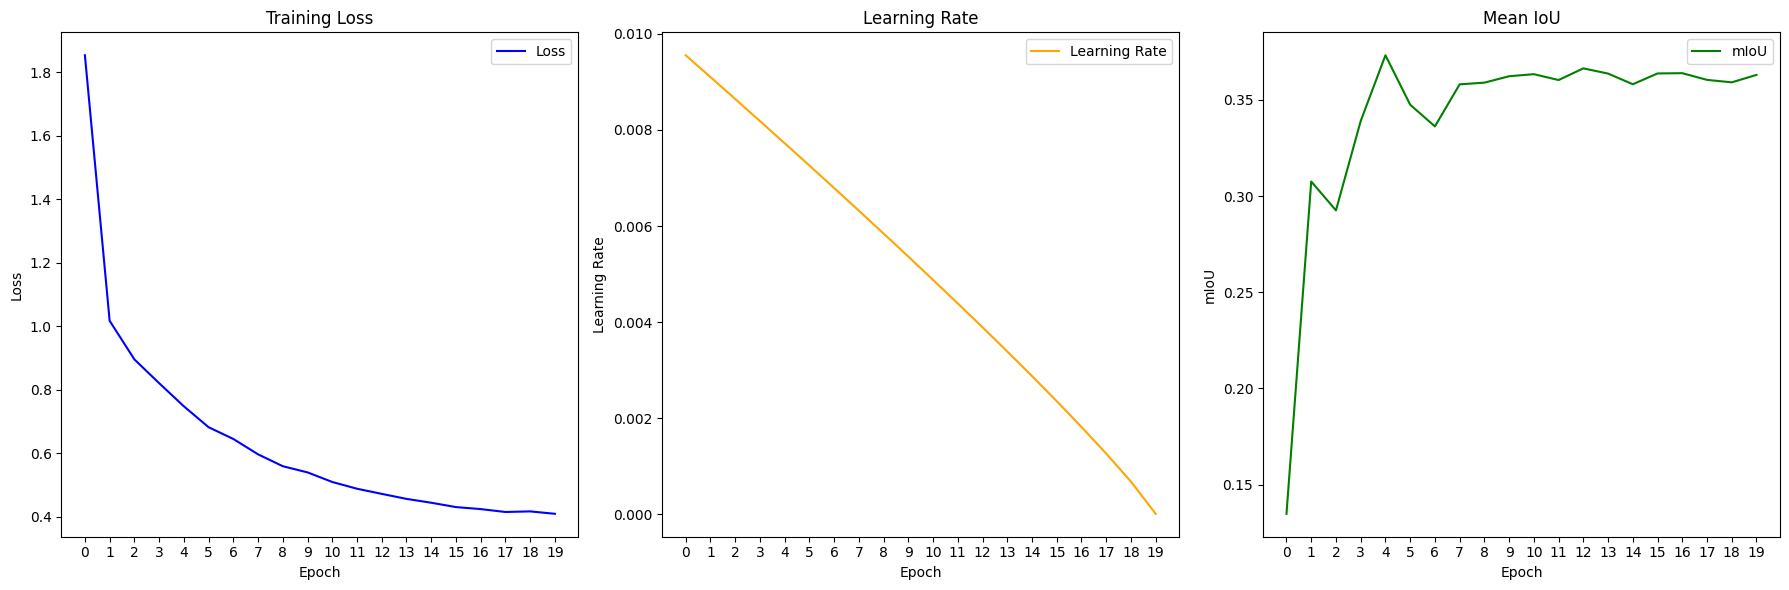

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(loss_history, lr_history, miou_history):
    """
    Function to plot loss, learning rate, and mIoU graph.

    Parameters:
    - loss_history: list containing loss values for each epoch.
    - lr_history: list containing learning rate values for each epoch.
    - miou_history: list containing mIoU values calculated every 5 epochs.
    """
    plt.figure(figsize=(18, 6))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(loss_history, label='Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.xticks(range(len(loss_history)))  # Set xticks as integer numbers

    # Learning Rate plot
    plt.subplot(1, 3, 2)
    plt.plot(lr_history, label='Learning Rate', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate')
    plt.legend()
    plt.xticks(range(len(lr_history)))  # Set xticks as integer numbers

    # mIoU plot
    plt.subplot(1, 3, 3)
    plt.plot(miou_history, label='mIoU', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.title('Mean IoU')
    plt.legend()
    plt.xticks(range(len(miou_history)))  # Integer ticks every 5 epochs

    plt.tight_layout()
    plt.show()

if plot_training:
  # Plot the training metrics graph
  plot_training_metrics(loss_history, lr_history, miou_history)